# Marginalized Gaussian Mixture Model on Source activity simulation of a selected brain region

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [115]:
import theano
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla

import pymc3 as pm
import arviz as az


In [34]:
from scipy.stats import norm

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [7]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [9]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [10]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PPCA'

In [11]:
Sim_data=np.load(cwd+'/data_input_files/data_input_mpr_slnet_decim360_001.npz')

In [12]:
for elemets in Sim_data.keys():
    print (elemets)

nd
nn
nt
dt
nsigma
Ts
t0
ds_decim
G
SC
Obs_v
Obs_r
delta_true
eta_true
J_true
rlim
vlim


In [13]:
nn=Sim_data['nn']
Ts=Sim_data['Ts']
Obs_v=Sim_data['Obs_v']
Obs_r=Sim_data['Obs_r']

In [14]:
Obs_v.shape, Ts.shape

((84, 1667), (1667,))

In [15]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [16]:
Obs_v_scaled = scale(Obs_v, -.15, 1.1)
#Obs_v_scaled = scale(Obs_v, 1., 2.)

In [17]:
Obs_v_scaled.shape

(84, 1667)

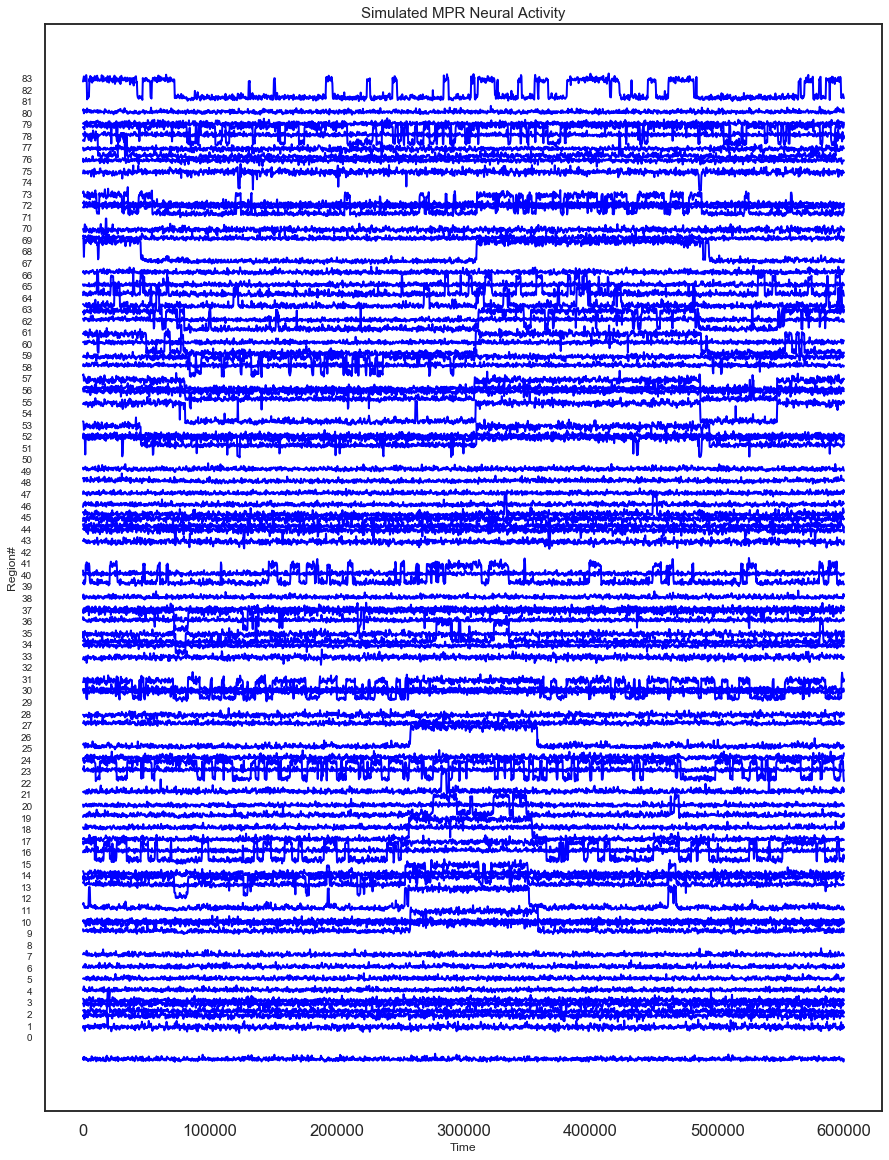

In [18]:
plt.figure(figsize=(15,20))
plt.plot(Ts, Obs_v.T + np.r_[0:nn], '-b', linewidth=2)
plt.yticks(np.r_[0:nn], np.r_[0:nn], fontsize=10)
plt.title("Simulated MPR Neural Activity",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_SyntheticSource.png"))
plt.show()

# Selecting Some node activities 

In [19]:
Ns_=np.array([0, 16, 36, 66, 78, 83])

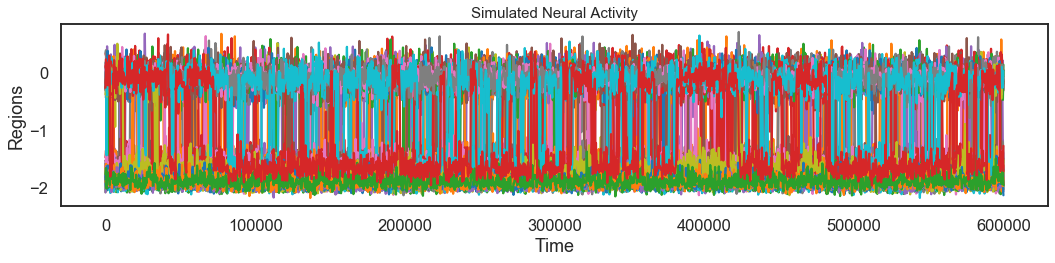

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(Ts, Obs_v.T)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSource_nn.png"))
plt.show()     

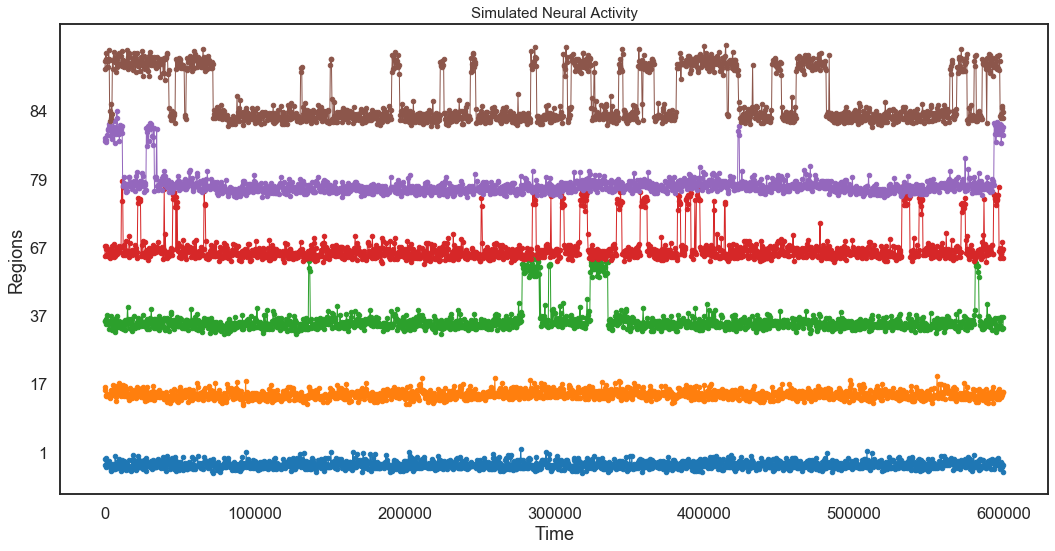

In [21]:
plt.figure(figsize=(15, 8))
i=0
for ii in (Ns_):
    i=i+1
    plt.plot(Ts, Obs_v[ii, :].T+ 2*i, '.-', lw=1)
plt.yticks(2*np.r_[0:Ns_.size]+.5, Ns_+1)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourceNodes_nn.png"))
plt.show()     

In [22]:
Obs_v.shape, Obs_r.shape

((84, 1667), (84, 1667))

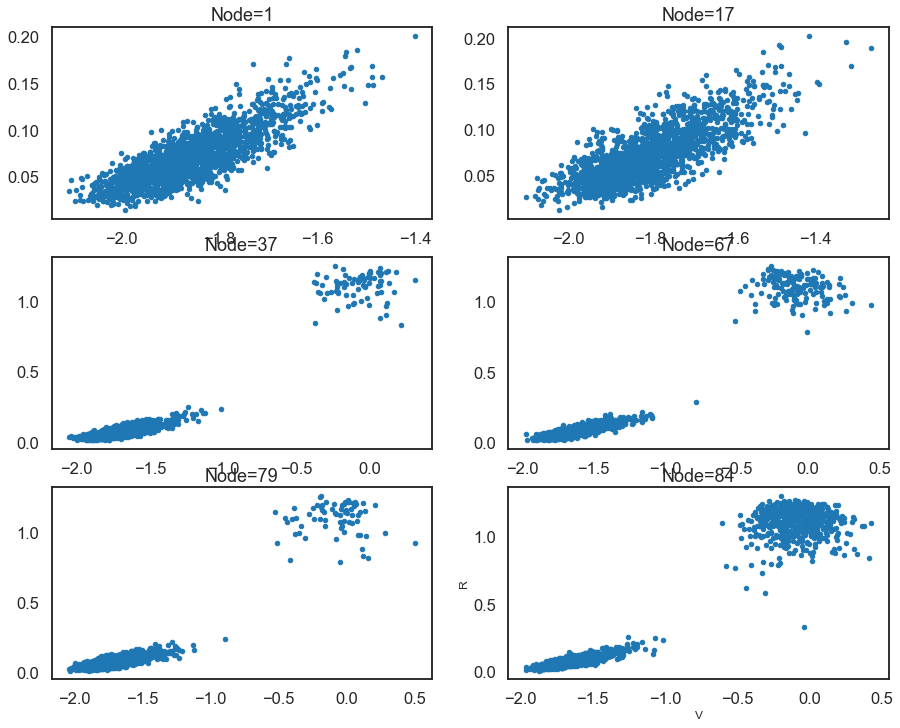

In [23]:
plt.figure(figsize=(15, 12))
i=0
for ii in (Ns_):
    i=i+1
    plt.subplot(3,2,i)
    plt.plot(Obs_v[ii, :], Obs_r[ii, :], '.', lw=.1)
    plt.title("Node={:d}".format((ii)+1))
plt.xlabel('V',fontsize=12)
plt.ylabel('R',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourcePhasePlaneRV.png"))
plt.show()     

# Gaussian Mixture Model on a selected brain region

In [218]:
ns=0

In [219]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [220]:
len(Obs_v[ns, :])

1667

In [221]:
N = len(Obs_v[ns, :])

In [222]:
x=Obs_v[ns, :]

In [223]:
x.shape

(1667,)

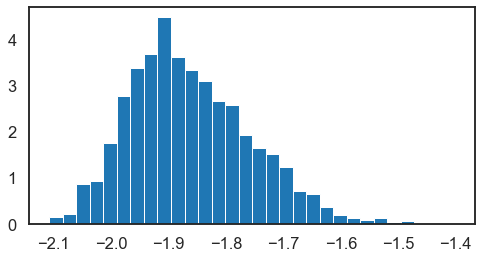

In [224]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(x, bins=30, normed=True,  lw=1);

In [225]:
# Fit a normal distribution to the data:
mu, std = norm.fit(x)

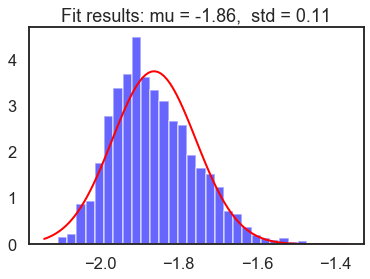

In [226]:
# Plot the histogram.
plt.hist(x, bins=30, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x_ = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_, mu, std)
plt.plot(x_, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()

In [227]:
W=np.ones((2))

In [228]:
np.ones_like(W)

array([1., 1.])

In [229]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))
    mu = pm.Normal('mu', 0., 10., shape=W.size)
    sigma = pm.Gamma('sigma', 1., 1., shape=W.size)
    x_obs = pm.NormalMixture('x_obs', w=w, mu=mu, sigma=sigma, observed=x)

In [230]:
with model:
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, w]
INFO:pymc3:NUTS: [sigma, mu, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:44<00:00, 178.34draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


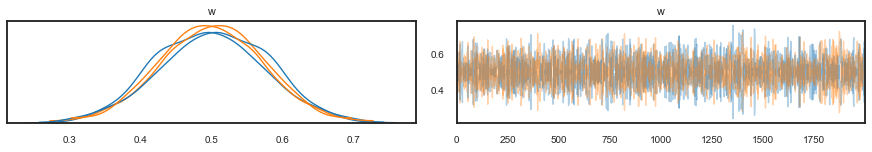

In [231]:
pm.traceplot(trace, var_names=['w']);

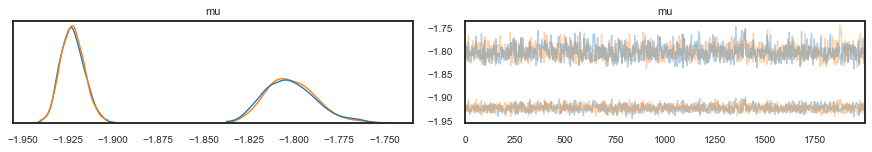

In [232]:
pm.traceplot(trace, var_names=['mu']);

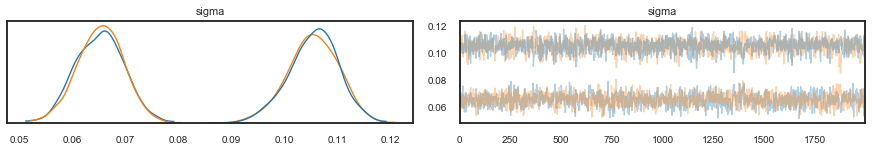

In [233]:
pm.traceplot(trace, var_names=['sigma']);

In [234]:
w=np.asarray(trace.get_values('w', burn=0, combine=False))
mu=np.asarray(trace.get_values('mu', burn=0, combine=False))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=False))

In [235]:
w.shape, mu.shape

((2, 2000, 2), (2, 2000, 2))

In [236]:
w_est=np.mean(w[1,:,:], axis=0)
mu_est=np.mean(mu[1,:,:], axis=0)
sigma_est=np.mean(sigma[1,:,:], axis=0)

In [237]:
w_est

array([0.5007318, 0.4992682])

In [238]:
mu_est

array([-1.80131766, -1.92244631])

In [239]:
sigma_est

array([0.10535355, 0.06528863])

In [240]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)

100%|██████████| 2000/2000 [01:23<00:00, 24.05it/s]


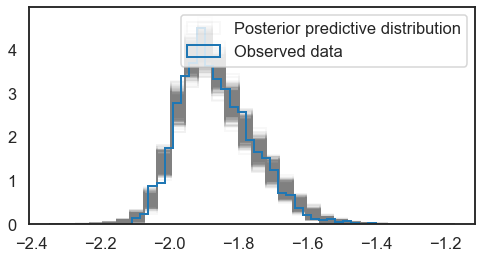

In [241]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [242]:
component = np.random.choice(mu_est.size, size=N, p=w_est)
x__ = np.random.normal(mu_est[component], sigma_est[component], size=N)

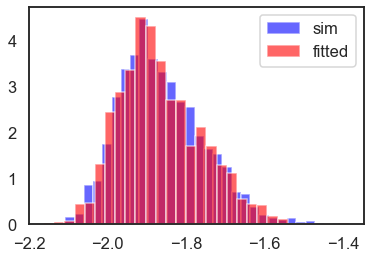

In [243]:
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', label='sim')
plt.hist(x__, bins=30, density=True, alpha=0.6, color='r', label='fitted')
plt.legend(loc=1);
plt.show()

In [56]:
ns=36

In [57]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [58]:
len(Obs_v[ns, :])

1667

In [59]:
N = len(Obs_v[ns, :])

In [60]:
x=Obs_v[ns, :]

In [61]:
x.shape

(1667,)

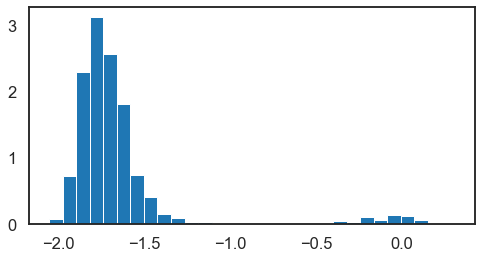

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(x, bins=30, normed=True,  lw=1);

In [68]:
# Fit a normal distribution to the data:
mu, std = norm.fit(x)

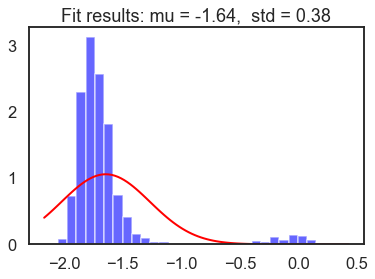

In [72]:
# Plot the histogram.
plt.hist(x, bins=30, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x_ = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_, mu, std)
plt.plot(x_, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()

In [200]:
W=np.ones((2))

In [201]:
np.ones_like(W)

array([1., 1.])

In [202]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))
    mu = pm.Normal('mu', 0., 10., shape=W.size)
    sigma = pm.Gamma('sigma', 1., 1., shape=W.size)
    x_obs = pm.NormalMixture('x_obs', w=w, mu=mu, sigma=sigma, observed=x)

In [203]:
with model:
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, w]
INFO:pymc3:NUTS: [sigma, mu, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:16<00:00, 490.36draws/s]


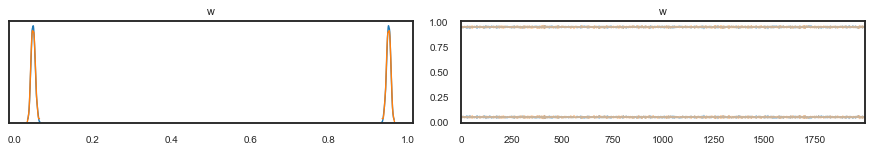

In [204]:
pm.traceplot(trace, var_names=['w']);

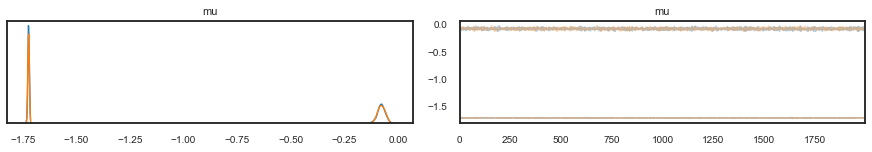

In [205]:
pm.traceplot(trace, var_names=['mu']);

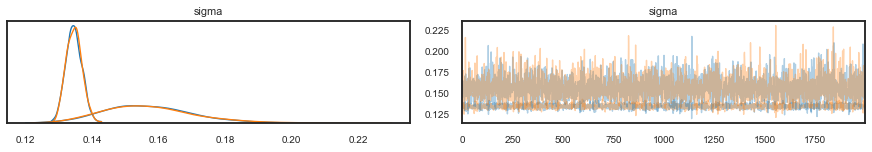

In [206]:
pm.traceplot(trace, var_names=['sigma']);

In [207]:
w=np.asarray(trace.get_values('w', burn=0, combine=False))
mu=np.asarray(trace.get_values('mu', burn=0, combine=False))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=False))

In [208]:
w.shape, mu.shape

((2, 2000, 2), (2, 2000, 2))

In [209]:
w_est=np.mean(w[1,:,:], axis=0)
mu_est=np.mean(mu[1,:,:], axis=0)
sigma_est=np.mean(sigma[1,:,:], axis=0)

In [210]:
w_est

array([0.95157705, 0.04842295])

In [211]:
mu_est

array([-1.72368115, -0.0763574 ])

In [212]:
sigma_est

array([0.13457785, 0.15717375])

In [213]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)

100%|██████████| 2000/2000 [01:18<00:00, 25.37it/s]


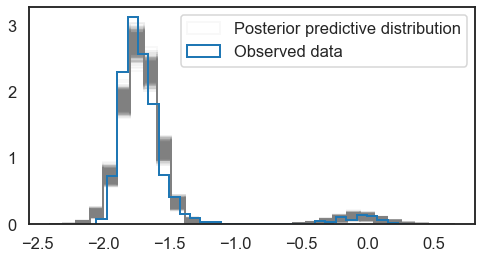

In [214]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [215]:
component = np.random.choice(mu_est.size, size=N, p=w_est)
x__ = np.random.normal(mu_est[component], sigma_est[component], size=N)

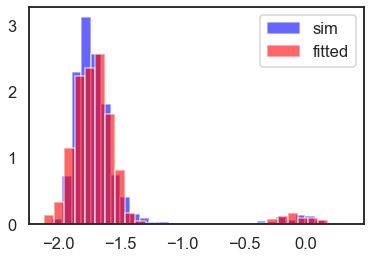

In [216]:
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', label='sim')
plt.hist(x__, bins=30, density=True, alpha=0.6, color='r', label='fitted')
plt.legend(loc=1);
plt.show()

In [76]:
ns=83

In [77]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [78]:
len(Obs_v[ns, :])

1667

In [79]:
N = len(Obs_v[ns, :])

In [80]:
x=Obs_v[ns, :]

In [81]:
x.shape

(1667,)

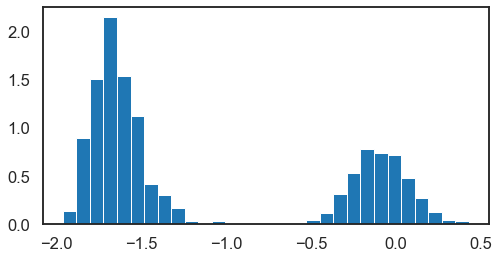

In [82]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(x, bins=30, normed=True,  lw=1);

In [83]:
# Fit a normal distribution to the data:
mu, std = norm.fit(x)

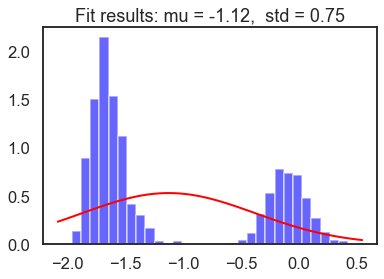

In [84]:
# Plot the histogram.
plt.hist(x, bins=30, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x_ = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_, mu, std)
plt.plot(x_, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()

In [85]:
W=np.ones((2))

In [38]:
np.ones_like(W)

array([1., 1.])

In [39]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))
    mu = pm.Normal('mu', 0., 10., shape=W.size)
    sigma = pm.Gamma('sigma', 1., 1., shape=W.size)
    x_obs = pm.NormalMixture('x_obs', w=w, mu=mu, sigma=sigma, observed=x)

In [40]:
with model:
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:13<00:00, 613.14draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


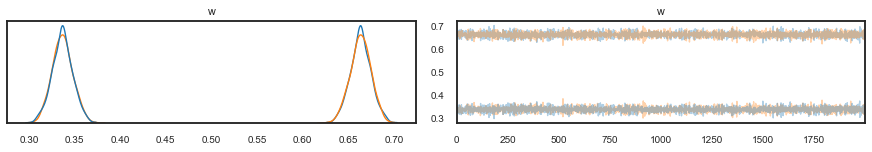

In [41]:
pm.traceplot(trace, var_names=['w']);

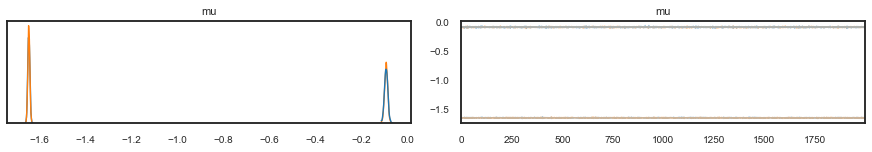

In [42]:
pm.traceplot(trace, var_names=['mu']);

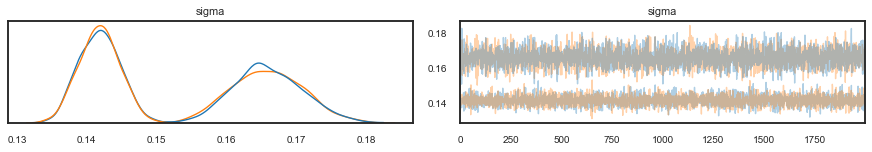

In [43]:
pm.traceplot(trace, var_names=['sigma']);

In [44]:
w=np.asarray(trace.get_values('w', burn=0, combine=False))
mu=np.asarray(trace.get_values('mu', burn=0, combine=False))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=False))

In [45]:
w.shape, mu.shape

((2, 2000, 2), (2, 2000, 2))

In [46]:
w_est=np.mean(w[1,:,:], axis=0)
mu_est=np.mean(mu[1,:,:], axis=0)
sigma_est=np.mean(sigma[1,:,:], axis=0)

In [47]:
w_est

array([0.33679498, 0.66320502])

In [48]:
mu_est

array([-0.09352745, -1.6463063 ])

In [49]:
sigma_est

array([0.16580938, 0.1417844 ])

In [50]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)

100%|██████████| 2000/2000 [01:27<00:00, 22.82it/s]


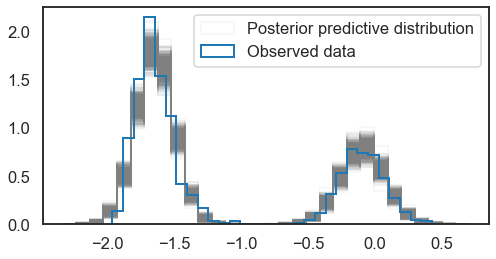

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [52]:
component = np.random.choice(mu_est.size, size=N, p=w_est)
x__ = np.random.normal(mu_est[component], sigma_est[component], size=N)

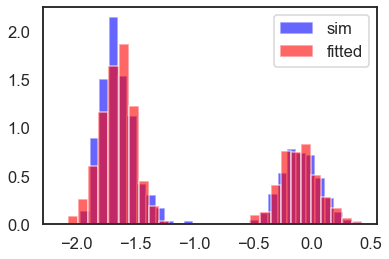

In [53]:
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', label='sim')
plt.hist(x__, bins=30, density=True, alpha=0.6, color='r', label='fitted')
plt.legend(loc=1);
plt.show()

In [138]:
W=np.ones((3))

In [139]:
np.ones_like(W)

array([1., 1., 1.])

In [140]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))
    mu = pm.Normal('mu', 0., 10., shape=W.size)
    sigma = pm.Gamma('sigma', 1., 1., shape=W.size)
    x_obs = pm.NormalMixture('x_obs', w=w, mu=mu, sigma=sigma, observed=x)

In [141]:
with model:
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:35<00:00, 224.58draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


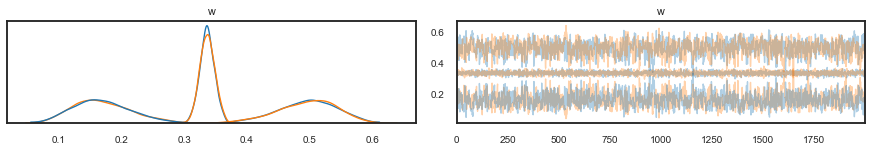

In [142]:
pm.traceplot(trace, var_names=['w']);

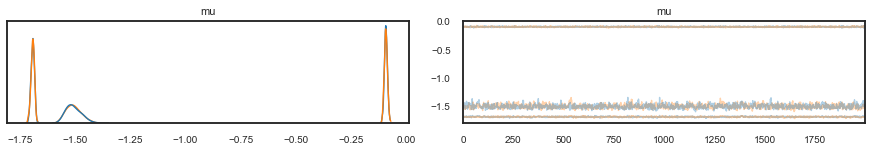

In [143]:
pm.traceplot(trace, var_names=['mu']);

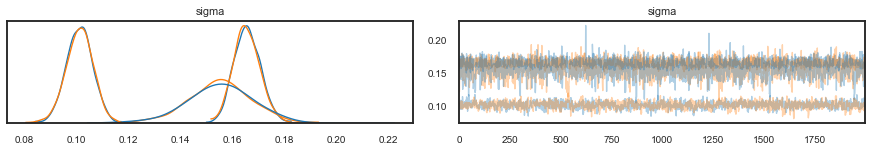

In [144]:
pm.traceplot(trace, var_names=['sigma']);

In [145]:
w=np.asarray(trace.get_values('w', burn=0, combine=False))
mu=np.asarray(trace.get_values('mu', burn=0, combine=False))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=False))

In [146]:
w.shape, mu.shape

((2, 2000, 3), (2, 2000, 3))

In [147]:
w_est=np.mean(w[1,:,:], axis=0)
mu_est=np.mean(mu[1,:,:], axis=0)
sigma_est=np.mean(sigma[1,:,:], axis=0)

In [148]:
w_est

array([0.16897812, 0.33676553, 0.49425634])

In [149]:
mu_est

array([-1.50584507, -0.0937253 , -1.69185609])

In [150]:
sigma_est

array([0.15512034, 0.16561348, 0.1012408 ])

In [151]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)

100%|██████████| 2000/2000 [01:18<00:00, 25.42it/s]


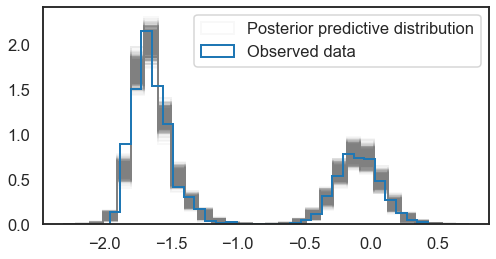

In [152]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [153]:
component = np.random.choice(mu_est.size, size=N, p=w_est)
x__ = np.random.normal(mu_est[component], sigma_est[component], size=N)

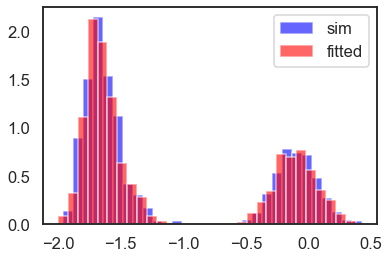

In [154]:
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', label='sim')
plt.hist(x__, bins=30, density=True, alpha=0.6, color='r', label='fitted')
plt.legend(loc=1);
plt.show()

In [92]:
GMM = pm.Model()

K=3

with GMM:
    p = pm.Dirichlet('p', a=np.array([1.]*K)) # Prior over z
    mu = pm.Normal('mu', mu=0., sd=10., shape=K)
    sigma = pm.HalfCauchy('sigma', beta=1., shape=K)
    z = pm.Categorical('z', p=p, shape=N)
    x_obs = pm.Normal('x_obs', mu=mu[z], sd=sigma[z], sigma=sigma, observed=x)

In [93]:
with GMM:
    step1 = pm.NUTS(vars=[p, mu, sigma])
    step2 = pm.ElemwiseCategorical(vars=[z])

    trace = pm.sample(draws=2000, step=[step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, mu, p]
>ElemwiseCategorical: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:31<00:00, 54.65draws/s]
The acceptance probability does not match the target. It is 0.9507297502317388, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


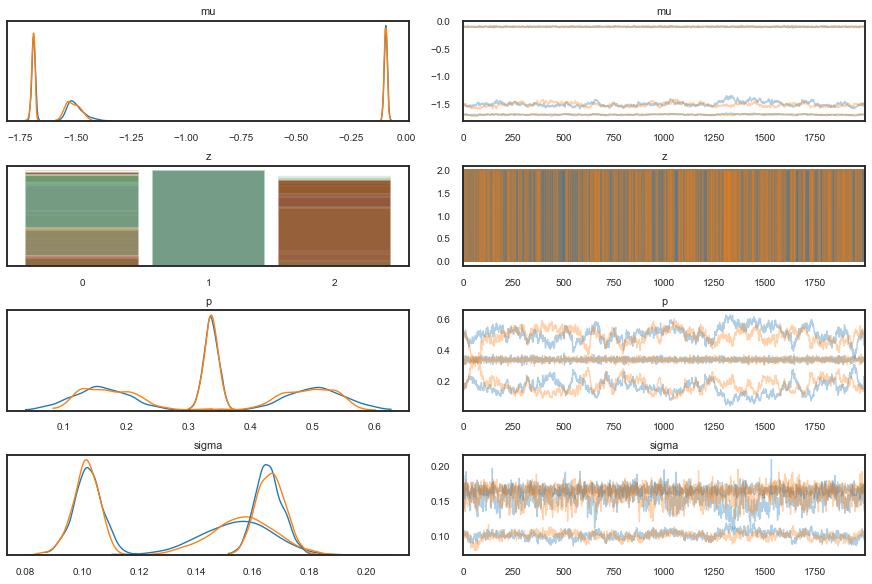

In [94]:
pm.traceplot(trace);

In [95]:
p=np.asarray(trace.get_values('p', burn=0, combine=False))
mu=np.asarray(trace.get_values('mu', burn=0, combine=False))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=False))

In [96]:
p.shape, mu.shape

((2, 2000, 3), (2, 2000, 3))

In [97]:
p_est=np.mean(p[1,:,:], axis=0)
mu_est=np.mean(mu[1,:,:], axis=0)
sigma_est=np.mean(sigma[1,:,:], axis=0)

In [98]:
p_est

array([0.17445008, 0.33666674, 0.48888318])

In [99]:
mu_est 

array([-1.51150353, -0.0940572 , -1.69228766])

In [100]:
sigma_est 

array([0.15650104, 0.16624278, 0.10106837])

In [101]:
with GMM:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)

100%|██████████| 2000/2000 [00:02<00:00, 934.28it/s]


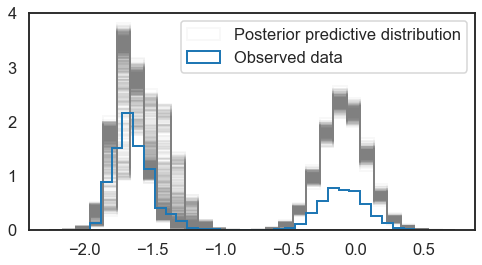

In [102]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [104]:
component = np.random.choice(mu_est.size, size=N, p=p_est)
x__ = np.random.normal(mu_est[component], sigma_est[component], size=N)

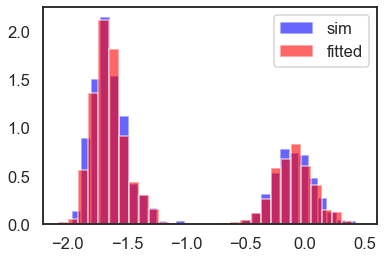

In [105]:
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', label='sim')
plt.hist(x__, bins=30, density=True, alpha=0.6, color='r', label='fitted')
plt.legend(loc=1);
plt.show()

In [107]:
## Build list of models We want a range of models ranging from K=1 to K=3
K_range = range(4)

# Initialize lists
GMM_list = []
trace_list = []

# Specify some sampling options
draws = 2000
nchains = 1

# Loop through K_range, building model and sampling each time
for ki in K_range:
    # Add a new Model object to the list
    GMM_list += [pm.Model()]
    K = ki+1 # Here ki is the index, K is the number of groups the model assumes

    # Name each model for easy identification during comparison
    GMM_list[ki].name = '%d-Group' % K

    with GMM_list[ki]:

            # Prior over z - only applicable if K>1
            if K>1:
                    p = pm.Dirichlet('p', a=np.array([1.]*K))

                    # z is the component that the data point is being sampled from. Since we have N data points, z should be a vector with N elements.
                    z = pm.Categorical('z', p=p, shape=N)

            # Prior over the component means and standard deviations
            mu = pm.Normal('mu', mu=0., sd=10., shape=K)
            sigma = pm.HalfCauchy('sigma', beta=1., shape=K)

            # Specify the likelihood
            if K>1:
                    x_obs = pm.Normal('x_obs', mu=mu[z], sd=sigma[z], observed=x)
                    # Specify the sampling algorithms to use
                    step1 = pm.NUTS(vars=[p, mu, sigma])
                    step2 = pm.ElemwiseCategorical(vars=[z])
                    steps = [step1,step2]
            else:
                    x_obs = pm.Normal('x_obs', mu=mu, sd=sigma, observed=x)
                    # Specify the sampling algorithms to use - don't include z or p because they don't exist when K==1
                    step1 = pm.NUTS(vars=[mu, sigma])
                    steps = [step1]

            # Start the sampler, and save results in a new element of trace_list
            trace_list += [pm.sample(draws=draws,  step=steps)]

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1-Group_sigma, 1-Group_mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1610.47draws/s]
The acceptance probability does not match the target. It is 0.8879163172191743, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [2-Group_sigma, 2-Group_mu, 2-Group_p]
>ElemwiseCategorical: [2-Group_z]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:22<00:00, 60.68draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [3-Group_sigma, 3-Group_mu, 3-Group_p]
>ElemwiseCategorical: [3-Group_z]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:37<00:00, 51.40draws/s]
The acceptance probability does not match the target. It i

In [112]:
K_range

range(0, 4)

In [116]:
comp_df = az.compare({'m1' : trace_list[0], 
                      'm2' : trace_list[1],
                      'm3' : trace_list[2], 
                      'm4' : trace_list[3]}, 
                     ic='WAIC')
comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m4,0,-1875.42,278.03,0,1,32.0465,0,True,deviance
m3,1,-1834.56,206.983,40.8573,3.49222e-09,67.4155,2.8954,True,deviance
m2,2,-1604.94,4.63132,270.484,2.10587e-42,54.2523,32.2639,False,deviance
m1,3,3769.99,1.32412,5645.41,0,53.0312,57.1922,False,deviance


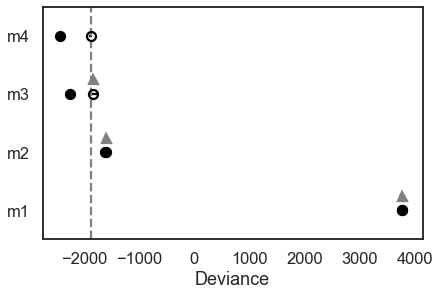

In [117]:
az.plot_compare(comp_df);
